<a href="https://colab.research.google.com/github/sasiidasariii/CURVETOPIA/blob/main/gfg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Model for isolated curves

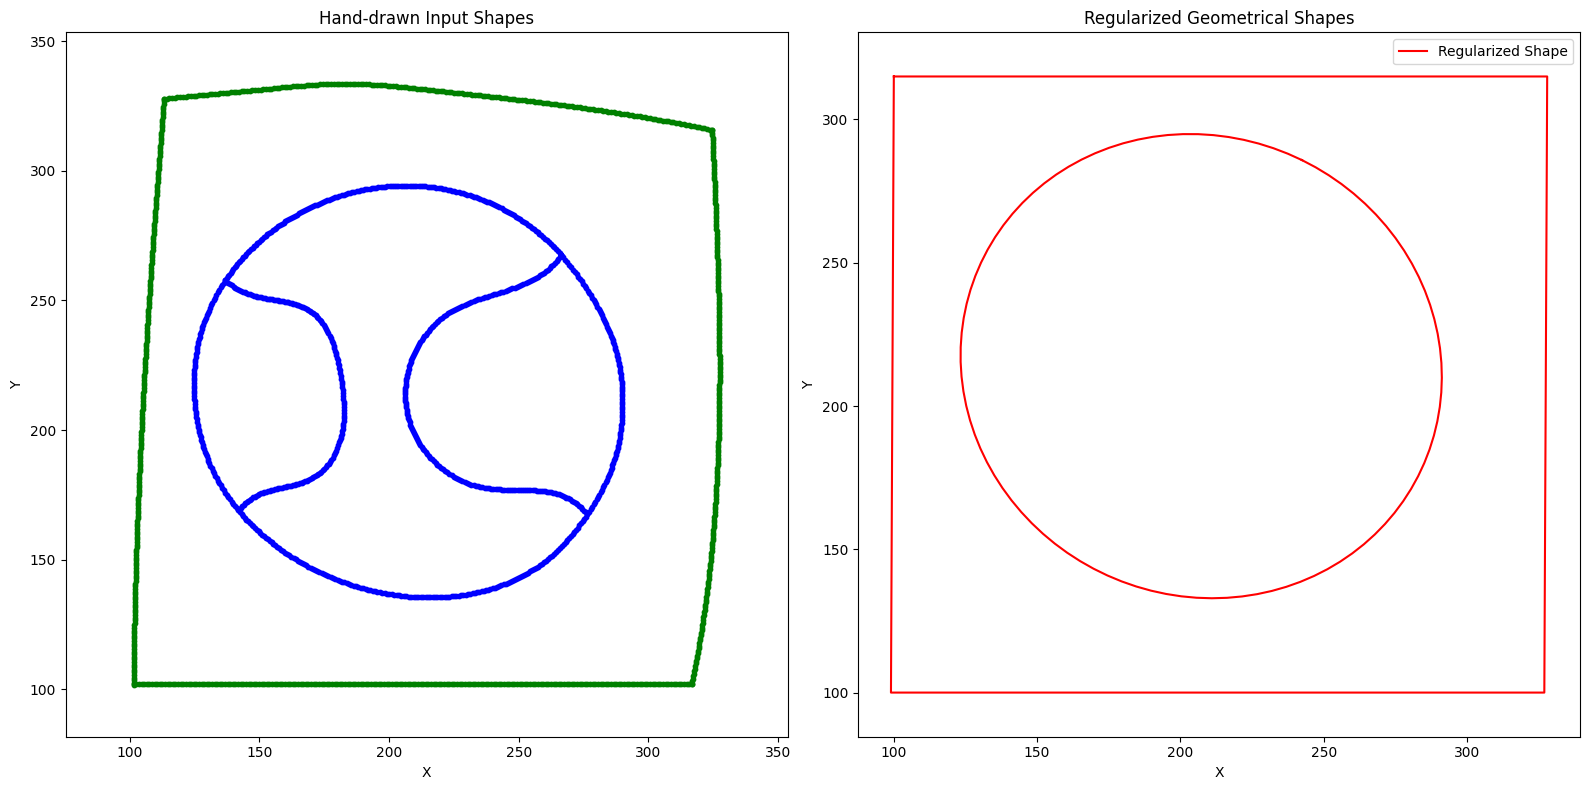

In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.optimize import minimize

# Load the input data
input_file = '/content/frag1.csv'
input_data = pd.read_csv(input_file)

# Extract and preprocess the data
x_coords = input_data.iloc[:, 2].values
y_coords = input_data.iloc[:, 3].values
points = np.column_stack((x_coords, y_coords))

# Translate points to spread shapes apart
def translate_points(points, offset):
    return points + offset

offset = np.array([100, 100])
points = translate_points(points, offset)

# Improved clustering parameters
dbscan = DBSCAN(eps=10, min_samples=5)
clusters = dbscan.fit_predict(points)

# Initialize an image for visualization
image_width = int(x_coords.max()) + 200
image_height = int(y_coords.max()) + 200
blank_image = np.zeros((image_height, image_width), dtype=np.uint8)

# Function to calculate the centroid of a contour
def calculate_centroid(contour):
    M = cv2.moments(contour)
    if M['m00'] == 0:
        return np.array([0, 0])
    return np.array([int(M['m10'] / M['m00']), int(M['m01'] / M['m00'])])

# Function to refine contour approximation with dynamic epsilon
def refine_contour(contour):
    arc_length = cv2.arcLength(contour, True)
    epsilon = 0.01 * arc_length  # Default epsilon for general cases

    approx = cv2.approxPolyDP(contour, epsilon, True)
    num_vertices = len(approx)

    if num_vertices == 3:
        epsilon = 0.02 * arc_length  # Larger epsilon for triangles
    elif num_vertices == 4:
        epsilon = 0.02 * arc_length  # Larger epsilon for rectangles and squares
    elif num_vertices == 5:
        epsilon = 0.015 * arc_length  # Larger epsilon for pentagons
    elif num_vertices == 6:
        epsilon = 0.015 * arc_length  # Larger epsilon for hexagons
    elif num_vertices == 7:
        epsilon = 0.015 * arc_length  # Larger epsilon for heptagons
    elif num_vertices == 8:
        epsilon = 0.015 * arc_length  # Larger epsilon for octagons
    elif num_vertices > 10:
        epsilon = 0.01 * arc_length  # Larger epsilon for circles
    elif 5 <= num_vertices <= 8:
        epsilon = 0.015 * arc_length  # Slightly larger epsilon for star shapes

    approx = cv2.approxPolyDP(contour, epsilon, True)
    return approx

# Function to reduce the number of points in the contour
def reduce_points(contour, max_points=100):
    if len(contour) > max_points:
        step = len(contour) // max_points
        return contour[::step]
    return contour

# Function to smooth shapes by interpolation
def interpolate_contour(contour, num_points=200):
    contour = contour.reshape(-1, 2)
    if len(contour) < 2:
        return contour
    dist = np.cumsum(np.sqrt(np.sum(np.diff(contour, axis=0) ** 2, axis=1)))
    dist = np.concatenate(([0], dist))
    interp_points = np.linspace(0, dist[-1], num=num_points)
    interpolated = np.zeros((num_points, 2))
    interpolated[:, 0] = np.interp(interp_points, dist, contour[:, 0])
    interpolated[:, 1] = np.interp(interp_points, dist, contour[:, 1])
    return interpolated

# Function to fit an ellipse using OpenCV
def fit_ellipse_least_squares(points):
    if len(points) < 5:
        return None
    ellipse = cv2.fitEllipse(np.array(points, dtype=np.int32))
    (cx, cy), (MA, ma), angle = ellipse
    angle_rad = np.radians(angle)
    t = np.linspace(0, 2 * np.pi, 100)
    ellipse_points = np.column_stack((
        cx + (MA / 2) * np.cos(t) * np.cos(angle_rad) - (ma / 2) * np.sin(t) * np.sin(angle_rad),
        cy + (MA / 2) * np.cos(t) * np.sin(angle_rad) + (ma / 2) * np.sin(t) * np.cos(angle_rad)
    ))
    return ellipse_points

# Function to fit a circle using least squares
def fit_circle_least_squares(points):
    def circle_cost(params):
        cx, cy, r = params
        distances = np.sqrt((points[:, 0] - cx) ** 2 + (points[:, 1] - cy) ** 2)
        return np.sum((distances - r) ** 2)

    cx_guess = np.mean(points[:, 0])
    cy_guess = np.mean(points[:, 1])
    r_guess = np.mean(np.sqrt((points[:, 0] - cx_guess) ** 2 + (points[:, 1] - cy_guess) ** 2))
    result = minimize(circle_cost, (cx_guess, cy_guess, r_guess), method='L-BFGS-B', bounds=[(-np.inf, np.inf), (-np.inf, np.inf), (0, np.inf)])
    cx, cy, r = result.x
    angles = np.linspace(0, 2 * np.pi, 100)
    circle_points = np.column_stack((cx + r * np.cos(angles), cy + r * np.sin(angles)))
    return circle_points

# Function to rotate points by a given angle around a centroid
def rotate_points(points, angle, centroid):
    angle_rad = np.radians(angle)
    cos_angle = np.cos(angle_rad)
    sin_angle = np.sin(angle_rad)
    translated_points = points - centroid
    rotated_points = np.array([
        [cos_angle * x - sin_angle * y, sin_angle * x + cos_angle * y]
        for x, y in translated_points
    ])
    return rotated_points + centroid

# Function to classify shapes and fit them accordingly
def classify_and_fit_shape(contour):
    refined_contour = refine_contour(contour)
    num_vertices = len(refined_contour)

    if num_vertices == 3:
        # Triangle
        return refined_contour.reshape(-1, 2)

    elif num_vertices == 4:
        # Rectangle or Rhombus
        rect = cv2.minAreaRect(refined_contour)
        box = cv2.boxPoints(rect)
        box = box.astype(np.intp)

        # Rotate rectangle to align it horizontally
        angle = rect[2]
        if angle < -45:
            angle += 90
        rotated_box = rotate_points(box, -angle, np.mean(box, axis=0))
        return rotated_box.astype(np.intp)

    elif num_vertices == 5:
        # Pentagon
        return refined_contour.reshape(-1, 2)

    elif num_vertices == 6:
        # Hexagon
        return refined_contour.reshape(-1, 2)

    elif num_vertices == 7:
        # Heptagon
        return refined_contour.reshape(-1, 2)

    elif num_vertices == 8:
        # Octagon
        return refined_contour.reshape(-1, 2)

    elif num_vertices > 10:
        # Fit ellipse for complex shapes with many points
        ellipse_points = fit_ellipse_least_squares(refined_contour.reshape(-1, 2))
        if ellipse_points is not None:
            return ellipse_points

    elif 5 <= num_vertices <= 8:
        # Handle star shapes
        approx = refined_contour.reshape(-1, 2)
        centroid = calculate_centroid(approx)
        angles = [np.arctan2(pt[1] - centroid[1], pt[0] - centroid[0]) for pt in approx]
        points = [(pt, angle) for pt, angle in zip(approx, angles)]
        points.sort(key=lambda x: x[1])
        outer_points = points[::2]
        inner_points = points[1::2]
        star_points = []
        for i in range(len(outer_points)):
            star_points.append(outer_points[i][0])
            if i < len(inner_points):
                star_points.append(inner_points[i][0])
        return np.array(star_points, dtype=np.int32)

    else:
        # Use interpolation for irregular shapes or very simple shapes
        return interpolate_contour(refined_contour, num_points=200)

# Process each cluster
regularized_points = []
for cluster_id in np.unique(clusters):
    if cluster_id == -1:
        continue  # Ignore noise points
    cluster_points = points[clusters == cluster_id]
    blank_image = np.zeros((image_height, image_width), dtype=np.uint8)

    for (x, y) in cluster_points:
        cv2.circle(blank_image, (int(x), int(y)), radius=1, color=(255), thickness=-1)

    contours, _ = cv2.findContours(blank_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Regularize shapes with improved handling
        if len(contour) >= 5:
            regularized_shape = classify_and_fit_shape(contour)
            if regularized_shape is not None:
                regularized_points.append(regularized_shape.reshape(-1, 2))
        else:
            regularized_shape = regularize_shape(contour)
            if regularized_shape is not None:
                regularized_points.append(regularized_shape.reshape(-1, 2))

if len(regularized_points) == 0:
    raise ValueError("No contours were detected and regularized!")

flat_points = np.vstack(regularized_points)
output_df = pd.DataFrame(flat_points, columns=["X", "Y"])

# Function to plot input shapes as dots
def plot_input_shapes_as_dots(ax, points, clusters, colours):
    for cluster_id in np.unique(clusters):
        if cluster_id == -1:
            continue  # Ignore noise points
        cluster_points = points[clusters == cluster_id]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colours[cluster_id % len(colours)], s=10)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.axis('equal')

# Function to plot shapes individually without connecting them
def plot_shapes_individually(ax, shapes, color, label):
    for shape in shapes:
        shape = np.vstack([shape, shape[0]])  # Close the shape
        ax.plot(shape[:, 0], shape[:, 1], color=color)
    if label is not None:
        ax.legend([label])
        label = None

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Define example colors
colours = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']

# Plot input shapes using dots and colors for each cluster
plot_input_shapes_as_dots(axes[0], points, clusters, colours)
axes[0].set_title('Hand-drawn Input Shapes')

# Plot regularized shapes
axes[1].set_title('Regularized Geometrical Shapes')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].axis('equal')

plot_shapes_individually(axes[1], regularized_points, color='red', label='Regularized Shape')

plt.tight_layout()
plt.show()
